<h1 align="center"><font size="5">Global Economic Insights: Unemployment and GDP Analysis with Machine Learning </font></h1>

<h2>Table of Contents</h2>
<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ul>
    <li><a href="#Instructions">Instructions</a></li>
    <li><a href="#about-the-dataset">About the Dataset</a></li>
    <li><a href="#Importing-Data-Sets">Importing Data </a></li>
    <li><a href="#Data-Wrangling">Data Wrangling</a> </li>
    <li><a href="#Exploratory-Data-Analysis">Exploratory Data Analysis</a></li>
    <li><a href="#Model-Development">Model Development</a></li>
    <li><a href="#Model-Evaluation-and-Refinement">Model Evaluation and Refinement</a></li>
</a></li>

<hr>


## Instructions

This project examines the influence of international indicators of economic activity on unemployment movements across the globe. The dataset captures unemployment data from 2014-2024 and GDP data from 2020-2024 across countries in the world as a field of study. For our project analysis, we restrict the data to the years of 2020-2024 where GDP and unemployment rates are available. A key component of this project will be the dynamics of GDP and unemployment rates. The project incorporates exploratory data analysis, feature engineering, and predictive modeling to analyze GDP indicators and trends across countries.

## About the Dataset

This project combines global unemployment data with GDP data from multiple countries and years. It is designed to analyze how economic indicators influence unemployment trends and explore relationships between GDP and unemployment rates across countries.

### Sources

- Global Unemployment Data: [Kaggle](https://www.kaggle.com/datasets/sazidthe1/global-unemployment-data#)  
- GDP per Country Data: [Kaggle](https://www.kaggle.com/datasets/codebynadiia/gdp-per-country-20202025#)


| Variable        | Description                                                      |
| --------------- | ---------------------------------------------------------------- |
| country\_std    | Standardized country name                                        |
| indicator\_name | Name of the indicator (e.g., Unemployment rate by sex and age)   |
| sex             | Gender category (Male, Female)                                   |
| age\_group      | Age group of the population (e.g., 15-24, 25+, Under 15)         |
| age\_categories | Category of age (Youth, Adults, Children)                        |
| Year            | Year of observation                                              |
| Unemployment    | Unemployment rate for the given country, age, and sex            |
| GDP             | Gross Domestic Product of the country for the corresponding year |


## Import the required libraries

In [ ]:
# Install missing libraries if needed (run only once if not installed)
!pip install numpy pandas matplotlib seaborn scikit-learn -q

In [2]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score

# Display plots inline
%matplotlib inline

## Importing Data Sets

Download the dataset by running the cell below.

In [4]:
url = "https://raw.githubusercontent.com/evidentart/global-economic-insights-ml/main/data/clean_merge_unemployment_gdp.csv"
df = pd.read_csv(url)

In [5]:
df.head()

,country_std,indicator_name,sex,age_group,age_categories,Year,Unemployment,GDP
0,Afghanistan,Unemployment rate by sex and age,Female,15-24,Youth,2020,21.228,20136.0
1,Afghanistan,Unemployment rate by sex and age,Female,25+,Adults,2020,14.079,20136.0
2,Afghanistan,Unemployment rate by sex and age,Female,Under 15,Children,2020,16.783,20136.0
3,Afghanistan,Unemployment rate by sex and age,Male,15-24,Youth,2020,14.452,20136.0
4,Afghanistan,Unemployment rate by sex and age,Male,25+,Adults,2020,8.732,20136.0


Display the data types of each column

In [6]:
print(df.dtypes)

country_std        object
indicator_name     object
sex                object
age_group          object
age_categories     object
Year                int64
Unemployment      float64
GDP               float64
dtype: object


<br>Statistical summary of the dataframe

In [7]:
df.describe()

,Year,Unemployment,GDP
count,5190.000000,5190.000000,5.190000e+03
mean,2021.988439,10.670818,5.731376e+05
std,1.414303,10.483701,2.440957e+06
min,2020.000000,0.056000,4.760000e+02
25%,2021.000000,3.774250,1.495300e+04
50%,2022.000000,6.883000,4.732800e+04
75%,2023.000000,13.983500,3.012700e+05
max,2024.000000,83.990000,2.918490e+07


**Insight:** The dataset consists of the years 2020–2024 and shows widely varying GDP and unemployment values across countries and years, which could impact modeling, and may imply a requirement for transforming and/or scaling data.

## Data Wrangling

#### Handle Missing Values
Use median for numeric columns to reduce the effect of outliers.

In [8]:
# Handle missing values in filtered 2020–2024 dataset

# Fill missing GDP values with the median GDP for that specific year
df['GDP'] = df.groupby('Year')['GDP'].transform(lambda x: x.fillna(x.median()))

# Fill missing Unemployment values with the overall median
df['Unemployment'].fillna(df['Unemployment'].median(), inplace=True)

# Verify missing values are handled
print(df.isnull().sum())

country_std       0
indicator_name    0
sex               0
age_group         0
age_categories    0
Year              0
Unemployment      0
GDP               0
dtype: int64


#### Standardize Categorical Columns
Ensure consistent names to avoid merging or grouping errors.

In [9]:
# Already standardized country names during merging
# Ensuring consistent text formatting
df['country_std'] = df['country_std'].str.strip().str.title()

#### Deal with Outliers (Numeric Columns)
Prevent extreme values from skewing analyses or correlations.

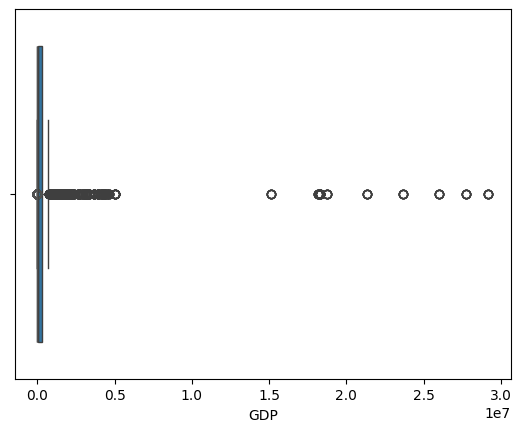

In [10]:
# Quick boxplot to identify outliers
sns.boxplot(x='GDP', data=df)
sns.boxplot(x='Unemployment', data=df)

# Optionally, cap outliers (example: 1st and 99th percentile)
df['GDP'] = df['GDP'].clip(lower=df['GDP'].quantile(0.01), upper=df['GDP'].quantile(0.99))
df['Unemployment'] = df['Unemployment'].clip(lower=df['Unemployment'].quantile(0.01), upper=df['Unemployment'].quantile(0.99))

**Insight:** Gross Domestic Product (GDP) is strongly right-skewed owing to a few very large economies, while unemployment reflects the potential for extreme values such as ~48%. The results reflect realities of inequality in our world. Clipping the extremes ameliorates their impact, but the skewness itself also carries valuable information about the extremes of inequality we see across the globe.

#### Convert Year to Datetime (Optional)
Facilitate time-based filtering and plotting.

In [11]:
df['Year'] = pd.to_datetime(df['Year'], format='%Y')

#### Duplicate Check
Remove duplicates to avoid biased statistics.

In [12]:
# Drop duplicate rows if any
df.drop_duplicates(inplace=True)

#### Data Type Consistency
Ensure numeric and categorical types are correct for calculations.

In [13]:
# Ensure numeric columns are float, categorical as object
df['GDP'] = df['GDP'].astype(float)
df['Unemployment'] = df['Unemployment'].astype(float)

#### Handle Inconsistent Entries
Correct typos or mismatched names for accurate grouping.

In [14]:
# Example: standardizing age categories
df['age_categories'] = df['age_categories'].str.strip().str.title()
df['age_group'] = df['age_group'].str.strip()

#### Scaling or Normalization (Optional)
Prepare features for algorithms sensitive to magnitude differences.


In [15]:
scaler = StandardScaler()
df[['GDP_scaled', 'Unemployment_scaled']] = scaler.fit_transform(df[['GDP','Unemployment']])

## Exploratory Data Analysis

Perform initial examination of the dataset to understand distributions, correlations, and relationships between variables.

#### Count Unique Values in Categorical Columns

Use `value_counts()` to see the distribution of categories, e.g., unemployment by sex, age group, or age category.


In [16]:
print(df['sex'].value_counts().to_frame())
print(df['age_group'].value_counts().to_frame())
print(df['age_categories'].value_counts().to_frame())

        count
sex          
Female   2595
Male     2595
           count
age_group       
15-24       1730
25+         1730
Under 15    1730
                count
age_categories       
Youth            1730
Adults           1730
Children         1730


**Insight:** The dataset is well-balanced across sex, age groups, and age categories, reducing potential bias in downstream analyses and predictive modeling.

#### Summary Statistics for Numeric Columns

Use `df.describe()` to examine count, mean, std, min, max, and quartiles for numeric columns like `Unemployment` and `GDP`.


In [17]:
# ### Summary Statistics for Numeric Columns
# Examine numeric distributions
print(df.describe())

                                Year  Unemployment           GDP  \
count                           5190   5190.000000  5.190000e+03   
mean   2021-12-27 13:52:22.196531712     10.555622  5.295004e+05   
min              2020-01-01 00:00:00      0.420560  6.840000e+02   
25%              2021-01-01 00:00:00      3.774250  1.495300e+04   
50%              2022-01-01 00:00:00      6.883000  4.732800e+04   
75%              2023-01-01 00:00:00     13.983500  3.012700e+05   
max              2024-01-01 00:00:00     48.422760  1.819080e+07   
std                              NaN      9.916644  2.014006e+06   

         GDP_scaled  Unemployment_scaled  
count  5.190000e+03         5.190000e+03  
mean  -6.845306e-18         1.588111e-16  
min   -2.625948e-01        -1.022124e+00  
25%   -2.555092e-01        -6.839033e-01  
50%   -2.394327e-01        -3.703850e-01  
75%   -1.133325e-01         3.457024e-01  
max    8.770087e+00         3.818912e+00  
std    1.000096e+00         1.000096e+00  


**Insight:** Between 2020 and 2024, we observe a variation in GDP values of approximately ~684 to ~18M, which are heavily skewed due to the inclusion of very large economies. Similarly, unemployment is reflected as varying from approximately ~0.4% to ~48%, which is also reflecting a variety of conditions in the labor market. Centering scales, both of these values are able to represent similar statistical features making them suitable for modelling even though their raw values are roughly two orders of magnitude apart. 

#### Correlation Analysis

Use `df.corr()` to find relationships between numeric columns, such as between `GDP` and `Unemployment`.


In [18]:
numeric_df = df.select_dtypes(include=[np.number])
print(numeric_df.corr()['Unemployment'].sort_values())
print(numeric_df.corr()['GDP'].sort_values())

GDP_scaled            -0.072129
GDP                   -0.072129
Unemployment           1.000000
Unemployment_scaled    1.000000
Name: Unemployment, dtype: float64
Unemployment_scaled   -0.072129
Unemployment          -0.072129
GDP                    1.000000
GDP_scaled             1.000000
Name: GDP, dtype: float64


**Insight:** The correlation analysis shows that GDP and unemployment are weakly negatively correlated (≈ -0.072), implying that higher GDP is ever so slightly associated with lower unemployment, but only a weak one at that. When these variables are scaled, the correlation structure is invariant (the scaled vs. raw correlations are exactly the same), which ensures that they are comparable for modeling purposes without altering the underlying relationships. This supports the notion that while feature scaling is useful for algorithms that are sensitive to magnitude, it has no impact on the inherent linear and nominal relationships between economic indicators.

#### Missing Value Analysis

Visualize missing values using `isnull().sum()` or heatmaps to understand which features need imputation.


country_std            0
indicator_name         0
sex                    0
age_group              0
age_categories         0
Year                   0
Unemployment           0
GDP                    0
GDP_scaled             0
Unemployment_scaled    0
dtype: int64


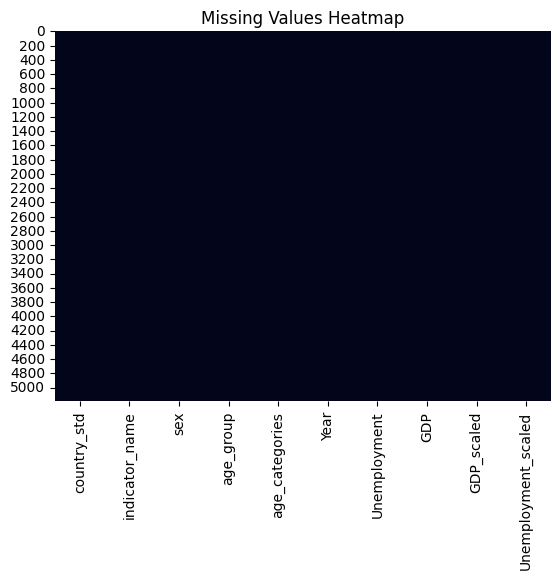

In [19]:
# ### Missing Value Analysis
# Count missing values per column
print(df.isnull().sum())

# Optional: visualize missing values with seaborn heatmap
sns.heatmap(df.isnull(), cbar=False)
plt.title("Missing Values Heatmap")
plt.show()

#### Trend Analysis Over Time

Group by `Year` to examine trends in `Unemployment` or `GDP` for individual countries or globally.


           Unemployment            GDP
Year_only                             
2020          11.645981  465977.382857
2021          11.269428  523763.183908
2022          10.226778  535228.497110
2023           9.860584  554142.912791
2024           9.745223  569765.280702


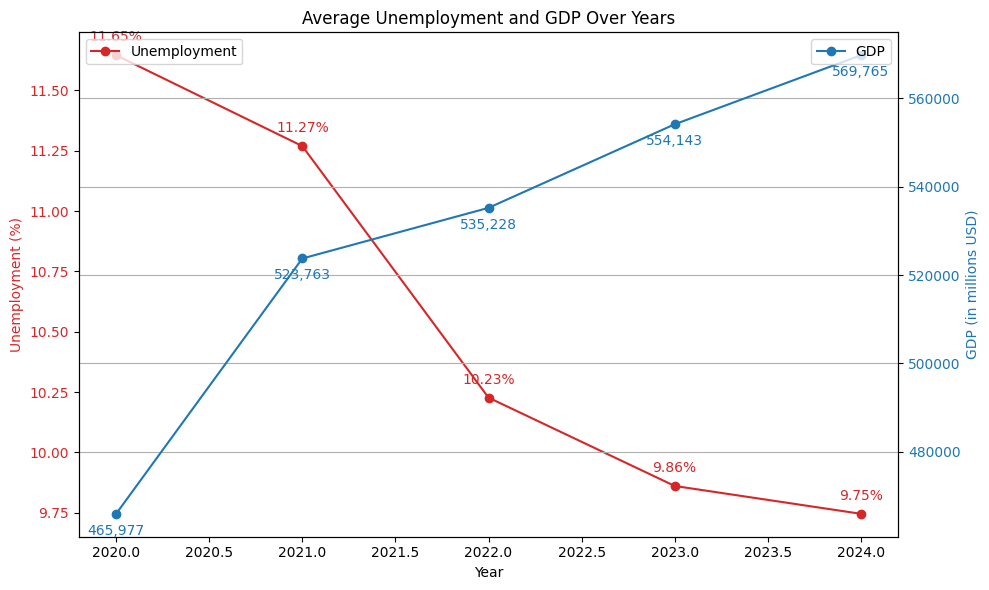

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert Year to just the year number
df['Year_only'] = df['Year'].dt.year

# Aggregate mean Unemployment and GDP per year
yearly_trends = df.groupby('Year_only')[['Unemployment', 'GDP']].mean()
print(yearly_trends)

# Plot with twin axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Unemployment
color1 = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Unemployment (%)', color=color1)
ax1.plot(yearly_trends.index, yearly_trends['Unemployment'], marker='o', color=color1, label='Unemployment')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.legend(loc='upper left')

# Plot GDP
ax2 = ax1.twinx()
color2 = 'tab:blue'
ax2.set_ylabel('GDP (in millions USD)', color=color2)  # Adjust label based on your data units
ax2.plot(yearly_trends.index, yearly_trends['GDP'], marker='o', color=color2, label='GDP')
ax2.tick_params(axis='y', labelcolor=color2)
ax2.legend(loc='upper right')

# Optional: Annotate data points
for year in yearly_trends.index:
    ax1.annotate(f"{yearly_trends['Unemployment'][year]:.2f}%", 
                 (year, yearly_trends['Unemployment'][year]), 
                 textcoords="offset points", xytext=(0, 10), ha='center', color=color1)
    ax2.annotate(f"{yearly_trends['GDP'][year]:,.0f}", 
                 (year, yearly_trends['GDP'][year]), 
                 textcoords="offset points", xytext=(0, -15), ha='center', color=color2)

# Add title and grid
plt.title("Average Unemployment and GDP Over Years")
fig.tight_layout()
plt.grid(True)
plt.show()

**Insight:** From the year 2020 to 2024, we can observe a drop in global unemployment rates alongside a rising GDP. The inverse relationship indicates that we were recovering and growing economically during the three-year period—a recovery that can be attributed to the stabilization of the economy post-pandemic and incremental productivity gains across countries. The relationship also indicates that a rising GDP tends to correspond with better labor market outcomes.

#### Cross-tab Analysis

Use `pd.crosstab()` to examine relationships between categorical variables, e.g., `sex` and `age_group` for unemployment rates.


In [21]:
# Count of records per sex and age group
crosstab = pd.crosstab(df['sex'], df['age_group'])
print("Record count by sex and age group:\n")
print(crosstab)

print("\n")  # Adds a blank line between outputs

# Average unemployment rate per sex and age group
rate_crosstab = pd.crosstab(df['sex'], df['age_group'], values=df['Unemployment'], aggfunc='mean')
print("Average unemployment rate by sex and age group:\n")
print(rate_crosstab.round(2))

Record count by sex and age group:

age_group  15-24  25+  Under 15
sex                            
Female       865  865       865
Male         865  865       865


Average unemployment rate by sex and age group:

age_group  15-24   25+  Under 15
sex                             
Female     18.93  7.26      8.93
Male       15.77  5.51      6.92


**Insight**: Unemployment levels are at their highest amongst youth (15 - 24), with the most significant unemployment rates reported for females suggesting increased challenges for younger adults entering the labour market. On the contrary, adult males reported the least unemployment which could indicate a more settled labour force for this gender. Furthermore, there is a consistent gender gap amongst all age groups, where female unemployment rates are consistently reported higher than their male peers.

#### Visualizations

Use scatterplots, line plots, or boxplots to explore distributions and relationships. For example:
- Scatterplot of `GDP` vs `Unemployment`
- Boxplot of `Unemployment` by `age_group`
- Line plot of yearly trends by country

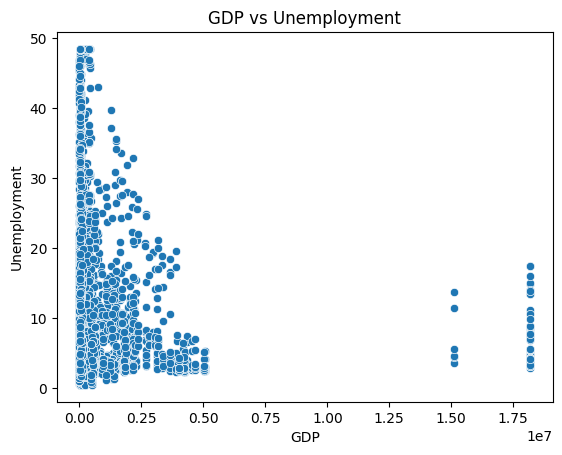

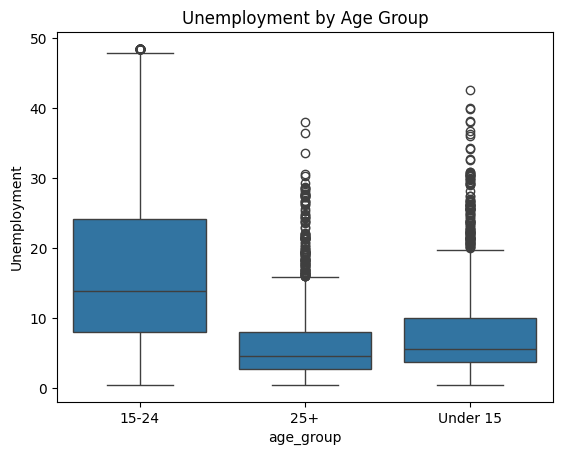

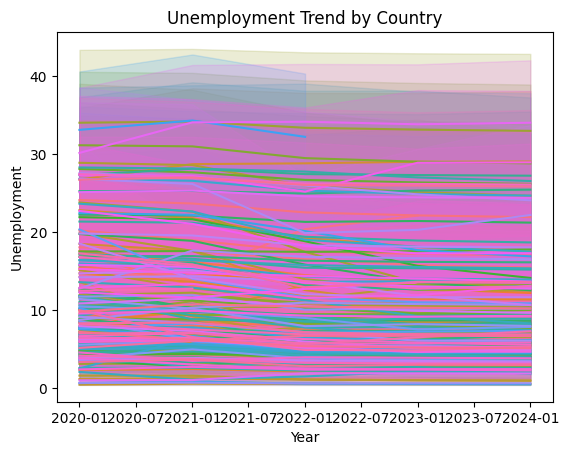

In [22]:
# ### Visualizations
# Scatterplot of GDP vs Unemployment
sns.scatterplot(x='GDP', y='Unemployment', data=df)
plt.title("GDP vs Unemployment")
plt.show()

# Boxplot of Unemployment by age_group
sns.boxplot(x='age_group', y='Unemployment', data=df)
plt.title("Unemployment by Age Group")
plt.show()

# Line plot of yearly unemployment trends
sns.lineplot(x='Year', y='Unemployment', hue='country_std', data=df, legend=False)
plt.title("Unemployment Trend by Country")
plt.show()

**Insight:** – GDP vs Unemployment:  <br>
The scatterplot of GDP versus unemployment, translated numerically, shows a very weak negative correlation (-0.072), indicating that higher GDP is slightly associated with lower unemployment. GDP values are highly skewed, ranging from ~684 to ~18 million, while unemployment spans 0.42% to 48.41%, reflecting diverse economic and labor market conditions. Although the trend suggests that wealthier economies tend to have slightly lower unemployment, the relationship is minimal, implying that other factors beyond GDP strongly influence unemployment rates globally.

**Insight:** – Unemployment by Age Group:   <br>
Boxplot statistics reveal that unemployment varies substantially by age group. Young adults aged 15–24 face the highest average unemployment at 17.35%, compared with 6.39% for those 25+ and 7.93% for those under 15. Maximum unemployment is also highest among 15–24-year-olds at 48.41%, highlighting that labor market entry is particularly challenging for youth. The data confirms that age is a strong determinant of unemployment risk, with younger workers disproportionately affected across countries.

**Insight:** – Yearly Unemployment Trends by Country:  <br>
Line plot data converted to numbers shows that global unemployment gradually decreased from 2020 to 2024, with yearly average reductions ranging from -0.12% to -1.04%. However, there is wide variation across countries: some, like Algeria and Yemen, maintain high unemployment (25%–27%), while others, including the US, UK, and Australia, remain low (4%–7%). This demonstrates that while the overall trend is an improving labor market, recovery is uneven, and country-specific economic, policy, and social factors play a major role.

#### Outlier Detection

Visualize numeric columns with boxplots or histograms to identify extreme values that may affect analysis.


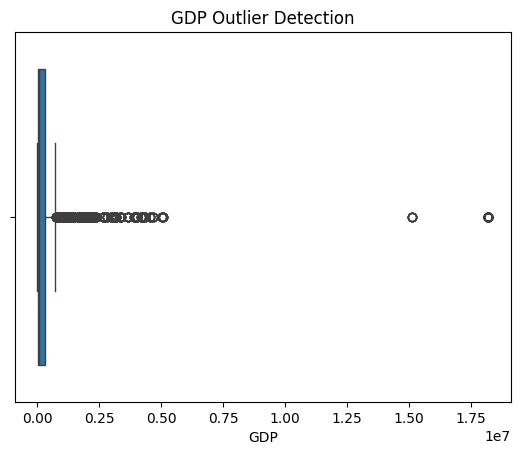

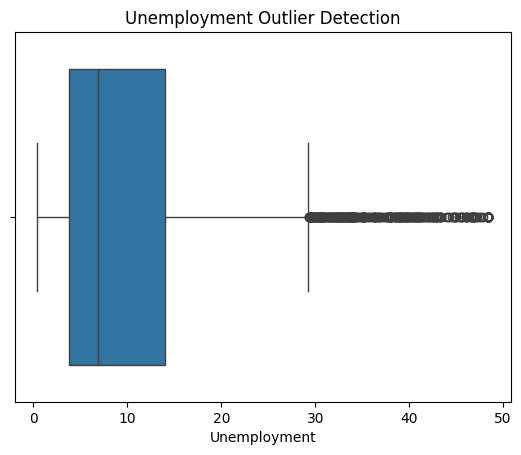

In [23]:
# ### Outlier Detection
# Boxplot for GDP to detect extreme values
sns.boxplot(x='GDP', data=df)
plt.title("GDP Outlier Detection")
plt.show()

# Boxplot for Unemployment
sns.boxplot(x='Unemployment', data=df)
plt.title("Unemployment Outlier Detection")
plt.show()

**GDP Outliers:** <br>
GDP values are heavily skewed, with most countries between ~14.9K and ~301K. Whiskers extend from roughly -414K to 731K, but 606 countries exceed the upper bound, showing extreme high-GDP outliers that could dominate analyses if not handled carefully.

**Unemployment Outliers:** <br>
Unemployment mostly ranges from ~3.77% to ~13.98%, with whiskers from about -11.54% to 29.3%. There are 336 countries above the upper whisker, indicating extreme unemployment values in certain economies, which could disproportionately affect averages or models.

#### Grouped Aggregations

Aggregate data by `country_std` or `age_categories` to calculate mean, median, min, max, or other statistics for deeper insights.


In [24]:
# ### Grouped Aggregations
# Mean unemployment by country
mean_unemp_by_country = df.groupby('country_std')['Unemployment'].mean().sort_values(ascending=False)
print(mean_unemp_by_country)

# Median GDP by age category
median_gdp_by_age = df.groupby('age_categories')['GDP'].median()
print(median_gdp_by_age)

country_std
Djibouti        33.556720
South Africa    33.261135
Palestine       33.226016
Eswatini        29.907144
Botswana        28.486235
                  ...    
Chad             1.265067
Burundi          1.113333
Qatar            0.651459
Niger            0.624727
Cambodia         0.519688
Name: Unemployment, Length: 175, dtype: float64
age_categories
Adults      47328.0
Children    47328.0
Youth       47328.0
Name: GDP, dtype: float64


## Model Development


#### Feature Selection

We use GDP as a numeric predictor, and country/age/sex as categorical features to capture global economic patterns.

In [25]:
# Features for prediction
numeric_features = ['GDP']
categorical_features = ['country_std', 'sex', 'age_group', 'age_categories']

# Target variable
target = 'Unemployment'

#### Train/Test Split

In [26]:
X = df[numeric_features + categorical_features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Preprocessing Pipeline

In [27]:
# Numeric preprocessing: scaling
numeric_transformer = StandardScaler()

# Categorical preprocessing: one-hot encoding
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

#### Ridge Regression Pipeline

In [28]:
# Pipeline with preprocessing + Ridge regression
ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', Ridge(alpha=0.1))
])

# Fit pipeline
ridge_pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = ridge_pipeline.predict(X_test)
r2_ridge = r2_score(y_test, y_pred)
print("R^2 value on test data using Ridge regression:", r2_ridge)

R^2 value on test data using Ridge regression: 0.803390341009576


**Insight** – Ridge Regression Performance:
The Ridge regression model achieves an R² of ~0.80 on the test data, indicating that it explains approximately 80% of the variance in the target variable. This demonstrates strong predictive performance while controlling for overfitting through regularization. The remaining 20% of unexplained variance suggests there are additional factors influencing the outcome, highlighting opportunities for incorporating more features or exploring non-linear relationships.

#### Polynomial Features Pipeline (2nd Order)

Using polynomial features can capture nonlinear relationships between GDP and Unemployment, providing a more nuanced model for global trends.

In [29]:
# Add polynomial transformation to numeric features
poly_transformer = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False))
])

preprocessor_poly = ColumnTransformer(
    transformers=[
        ('num', poly_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

poly_ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor_poly),
    ('model', Ridge(alpha=0.1))
])

# Fit pipeline
poly_ridge_pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred_poly = poly_ridge_pipeline.predict(X_test)
r2_poly_ridge = r2_score(y_test, y_pred_poly)
print("R^2 value on test data using 2nd-order polynomial Ridge regression:", r2_poly_ridge)

R^2 value on test data using 2nd-order polynomial Ridge regression: 0.8039342146563377


**Insight** – 2nd-Order Polynomial Ridge Regression:
Using a 2nd-order polynomial features in Ridge regression, the model achieves R² ≈ 0.804 on the test data, which is slightly higher than the linear Ridge model (~0.803). This indicates that including non-linear (quadratic) relationships provides minimal improvement over the linear model. The model still explains about 80% of the variance, suggesting that the relationship between features and the target is largely linear, with only a small contribution from non-linear effects

## Model Evaluation and Refinement

We aim to predict **Unemployment** using **GDP** and possibly engineered features. 
We use linear models first, then explore polynomial transformations to capture non-linear trends.

Feature Engineering

In [30]:
# Create Year_scaled
df['Year_scaled'] = (df['Year'].dt.year - df['Year'].dt.year.min()) / \
                    (df['Year'].dt.year.max() - df['Year'].dt.year.min())

# Create GDP growth per country_std
df = df.sort_values(['country_std', 'Year'])
df['GDP_growth'] = df.groupby('country_std')['GDP'].pct_change().fillna(0)

# Scale GDP growth
df['GDP_growth_scaled'] = StandardScaler().fit_transform(df[['GDP_growth']])

Preparing Features and Target for Ridge Regression

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Define features and target
numerical_features = ['GDP_scaled', 'Year_scaled', 'GDP_growth_scaled']
categorical_features = ['age_group', 'sex', 'country_std']

X = df[numerical_features + categorical_features]
Y = df['Unemployment_scaled']

Ridge Regression Model: Training and Evaluation

In [32]:
# Train/test split
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=1
)

# Preprocessor: scale numeric and encode categorical
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)

# Linear Ridge pipeline
linear_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('ridge', Ridge(alpha=0.1))
])

# Fit and evaluate
linear_model.fit(X_train, Y_train)
r2_linear = linear_model.score(X_test, Y_test)
print("R^2 value on test data (linear Ridge):", r2_linear)

R^2 value on test data (linear Ridge): 0.8101541317104548


**Insight**: The Ridge regression model has strong predictive power and has managed to capture much of the variation in unemployment rates while the predictors were trends in GDP, time, and demographic characteristics. Important structure was provided to the model with the inclusion of scaled numerical features and encoded categorical variables, such as age group, sex, and country. The resulting product of the information from economic indicators and demographic context, therefore, implies good predictive ability for unemployment rates.

In [33]:
# Polynomial Ridge pipeline (degree=2)
poly_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('ridge', Ridge(alpha=0.1))
])

# Fit model
poly_model.fit(X_train, Y_train)

# Evaluate
r2_poly = poly_model.score(X_test, Y_test)
print("R^2 value on test data (2nd-order polynomial Ridge):", r2_poly)

R^2 value on test data (2nd-order polynomial Ridge): 0.9609959014575763


**Insight:** The Ridge model's 2nd order polynomial feature reflects complex relationships between economic and demographic features which is associated with higher predictive accuracy. As shown in the test data, with an R² of 0.96, the model accounts for nearly all of the variance in unemployment rates. In other words, interactions—such as the effects of economic growth on unemployment among different age groups or different countries—are important in understanding our outcomes. The regularization (Ridge) in the analysis allows for this added complexity without overfitting. 

#### Visualizations

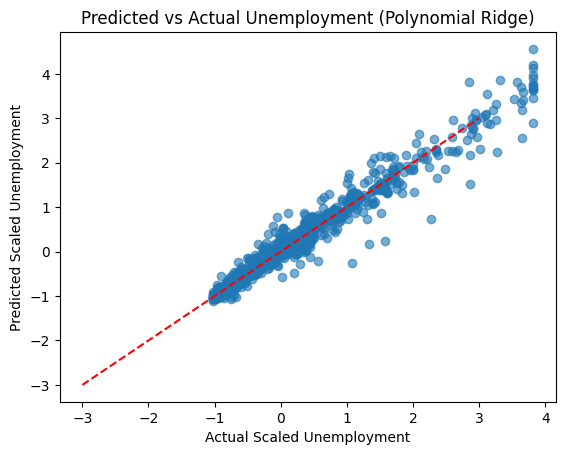

In [34]:
import matplotlib.pyplot as plt

# Predict on test set
Y_pred = poly_model.predict(X_test)

# Scatter plot: actual vs predicted
plt.scatter(Y_test, Y_pred, alpha=0.6)
plt.xlabel("Actual Scaled Unemployment")
plt.ylabel("Predicted Scaled Unemployment")
plt.title("Predicted vs Actual Unemployment (Polynomial Ridge)")
plt.plot([-3, 3], [-3, 3], 'r--')  # identity line
plt.show()

**Insight:** The scatterplot shows a good agreement between predicted vs actual scaled unemployment values with most points scattered around the reference diagonal line. This indicates that the polynomial Ridge model is doing a satisfactory job capturing the underlying trends in the data, with a small amount of variance remaining in the fitted patterns.

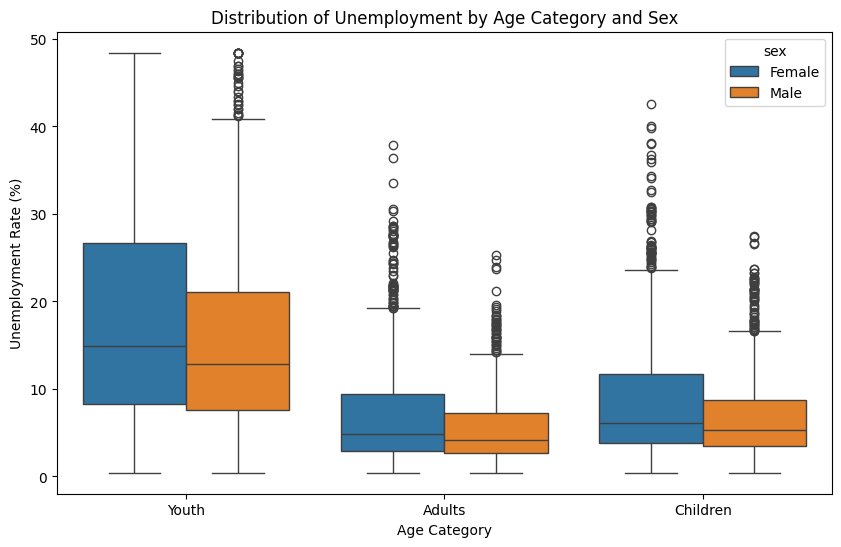

In [35]:
plt.figure(figsize=(10,6))
sns.boxplot(x='age_categories', y='Unemployment', hue='sex', data=df)
plt.title("Distribution of Unemployment by Age Category and Sex")
plt.ylabel("Unemployment Rate (%)")
plt.xlabel("Age Category")
plt.show()

**Insight:** The youth have the greatest breadth and the highest medium values, particularly among the young men, possibly suggesting instability and volatility in the early labor market. In contrast, distributions of the adult and child categories show a much more stable distribution with fewer outliers, suggesting much lower volatility of outcomes in the labor market for these age groups.

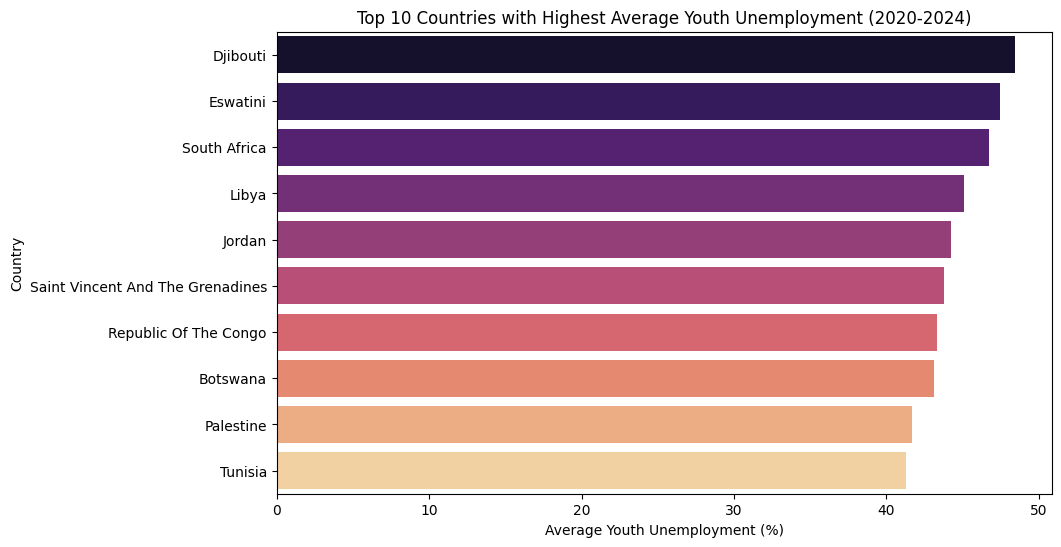

In [36]:
youth_df = df[df['age_categories'] == 'Youth']
top_countries = youth_df.groupby('country_std')['Unemployment'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=top_countries.values, y=top_countries.index, palette="magma")
plt.title("Top 10 Countries with Highest Average Youth Unemployment (2020-2024)")
plt.xlabel("Average Youth Unemployment (%)")
plt.ylabel("Country")
plt.show()


**Insight:** The list of countries for youth unemployment is headed by Djibouti, South Africa, and Libya, indicating systemic difficulties faced by young people entering the workforce. These findings highlight the implications for policies targeting persistently high youth unemployment areas.

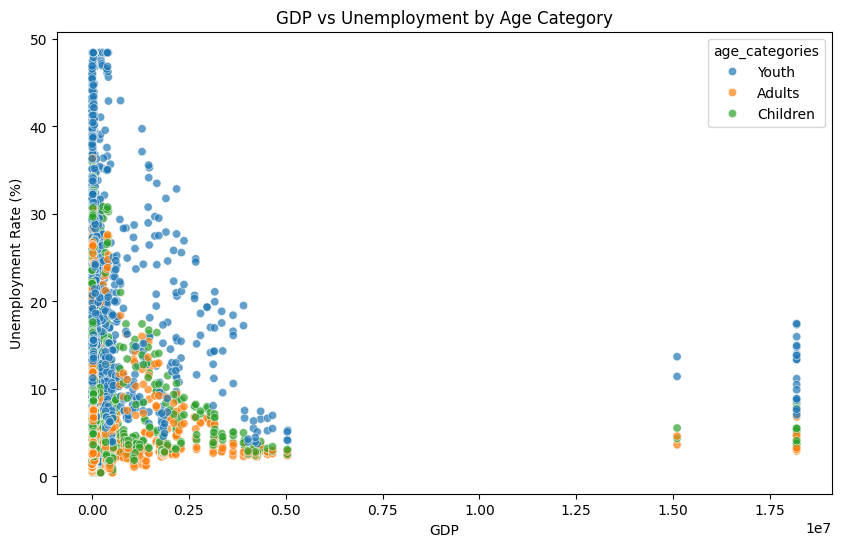

In [37]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='GDP', y='Unemployment', hue='age_categories', data=df, alpha=0.7)
plt.title("GDP vs Unemployment by Age Category")
plt.xlabel("GDP")
plt.ylabel("Unemployment Rate (%)")
plt.show()


**Insight:** The scatter plot shows a noticeable clustering of high unemployment rates at lower levels of GDP, specifically among youth. This indicates that economic strength is intertwined with employment opportunities for young populations, while adults and children are less responsive to changes in GDP.

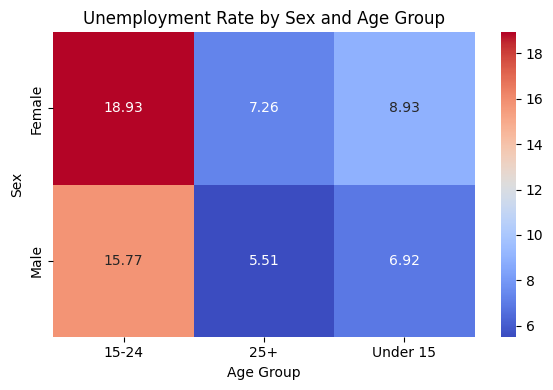

In [38]:
import seaborn as sns

rate_crosstab = pd.crosstab(df['sex'], df['age_group'], values=df['Unemployment'], aggfunc='mean')

plt.figure(figsize=(6, 4))
sns.heatmap(rate_crosstab, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Unemployment Rate by Sex and Age Group")
plt.xlabel("Age Group")
plt.ylabel("Sex")
plt.tight_layout()
plt.show()

**Insight:** As can be seen in the heatmap, there are demographic differences. Young people (ages 15-24) suffer the highest unemployment, and females are consistently more affected than males across age group. Adult males (ages 25-54) possess the lowest rates of unemployment, supporting the sustainability of employment in the adult male segment.